# 🦠 Exploration Interactive - Articles COVID-19

Ce notebook permet d'explorer les résultats du projet de classification d'articles scientifiques.

**Projet:** Classification et analyse d'articles CORD-19 avec NLP et Graph Neural Networks

## 📦 1. Imports et Configuration

In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
%matplotlib inline

print("✅ Configuration terminée")

✅ Configuration terminée


In [ ]:
pip install pandas numpy networkx matplotlib seaborn


In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModel
import community as community_louvain
import umap

print("✅ Numpy:", np.__version__)
print("✅ Pandas:", pd.__version__)
print("✅ NetworkX:", nx.__version__)
print("✅ PyTorch:", torch.__version__)
print("✅ Transformers: OK")
print("✅ UMAP: OK")
print("✅ Community (Louvain): OK")
print("\n🎉 Tout fonctionne parfaitement !")

✅ Numpy: 2.3.4
✅ Pandas: 2.3.3
✅ NetworkX: 3.5
✅ PyTorch: 2.9.0+cpu
✅ Transformers: OK
✅ UMAP: OK
✅ Community (Louvain): OK

🎉 Tout fonctionne parfaitement !


In [ ]:
pip install torch transformers python-louvain umap-learn

## 📂 2. Chargement des Données

In [13]:
# Chemins
PROJECT_ROOT = Path(r"C:\Users\lapte\Desktop\AL\project\S1_CORD19_Classification")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

print("📂 Chargement des données...")

# DataFrame
df = pd.read_csv(DATA_PROCESSED / "articles_with_communities.csv")
print(f"✅ {len(df):,} articles chargés")

# Embeddings
embeddings = np.load(DATA_PROCESSED / "embeddings.npy")
print(f"✅ Embeddings: {embeddings.shape}")

# Graphe
# graph = nx.read_gpickle(DATA_PROCESSED / "article_graph.gpickle")
with open(DATA_PROCESSED / "article_graph.gpickle", "rb") as f:
    graph = pickle.load(f)
print(f"✅ Graphe: {graph.number_of_nodes():,} nœuds, {graph.number_of_edges():,} arêtes")

# Communautés
with open(DATA_PROCESSED / "communities.pkl", 'rb') as f:
    communities = pickle.load(f)
print(f"✅ {len(set(communities.values()))} communautés")

print("\n✅ Toutes les données sont chargées!")

📂 Chargement des données...
✅ 816,359 articles chargés
✅ Embeddings: (816359, 384)
✅ Graphe: 816,359 nœuds, 4,783,609 arêtes
✅ 187 communautés

✅ Toutes les données sont chargées!


## 📊 3. Vue d'Ensemble

In [14]:
# Afficher les premières lignes
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,year,full_text,text_length,community
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,2001.0,Clinical features of culture-proven Mycoplasma...,1976,0
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2000.0,Nitric oxide: a pro-inflammatory mediator in l...,1060,1
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2000.0,Surfactant protein-D and pulmonary host defens...,1695,100
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2001.0,Role of endothelin-1 in lung disease Endotheli...,455,-1
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2001.0,Gene expression in epithelial cells in respons...,907,-1


In [20]:
# Statistiques globales
print("📊 STATISTIQUES GLOBALES")
print("="*60)

print(f"\n📚 Dataset:")
print(f"   - Total articles: {len(df):,}")
print(f"   - Avec abstract: {df['abstract'].notna().sum():,}")
print(f"   - Longueur moyenne: {df['full_text'].str.len().mean():.0f} caractères")

print(f"\n🕸️  Graphe:")
print(f"   - Nœuds: {graph.number_of_nodes():,}")
print(f"   - Arêtes: {graph.number_of_edges():,}")
print(f"   - Densité: {nx.density(graph):.6f}")
print(f"   - Degré moyen: {sum(dict(graph.degree()).values()) / graph.number_of_nodes():.2f}")

comm_sizes = pd.Series(communities.values()).value_counts()
print(f"\n🎯 Communautés:")
print(f"   - Nombre: {len(set(communities.values()))}")
print(f"   - Taille moyenne: {comm_sizes.mean():.1f} articles")
print(f"   - Plus grande: {comm_sizes.max()} articles")

📊 STATISTIQUES GLOBALES

📚 Dataset:
   - Total articles: 816,359
   - Avec abstract: 816,359
   - Longueur moyenne: 1575 caractères

🕸️  Graphe:
   - Nœuds: 816,359
   - Arêtes: 4,783,609
   - Densité: 0.000014
   - Degré moyen: 11.72

🎯 Communautés:
   - Nombre: 187
   - Taille moyenne: 4365.6 articles
   - Plus grande: 292706 articles


## 📈 4. Distribution des Communautés

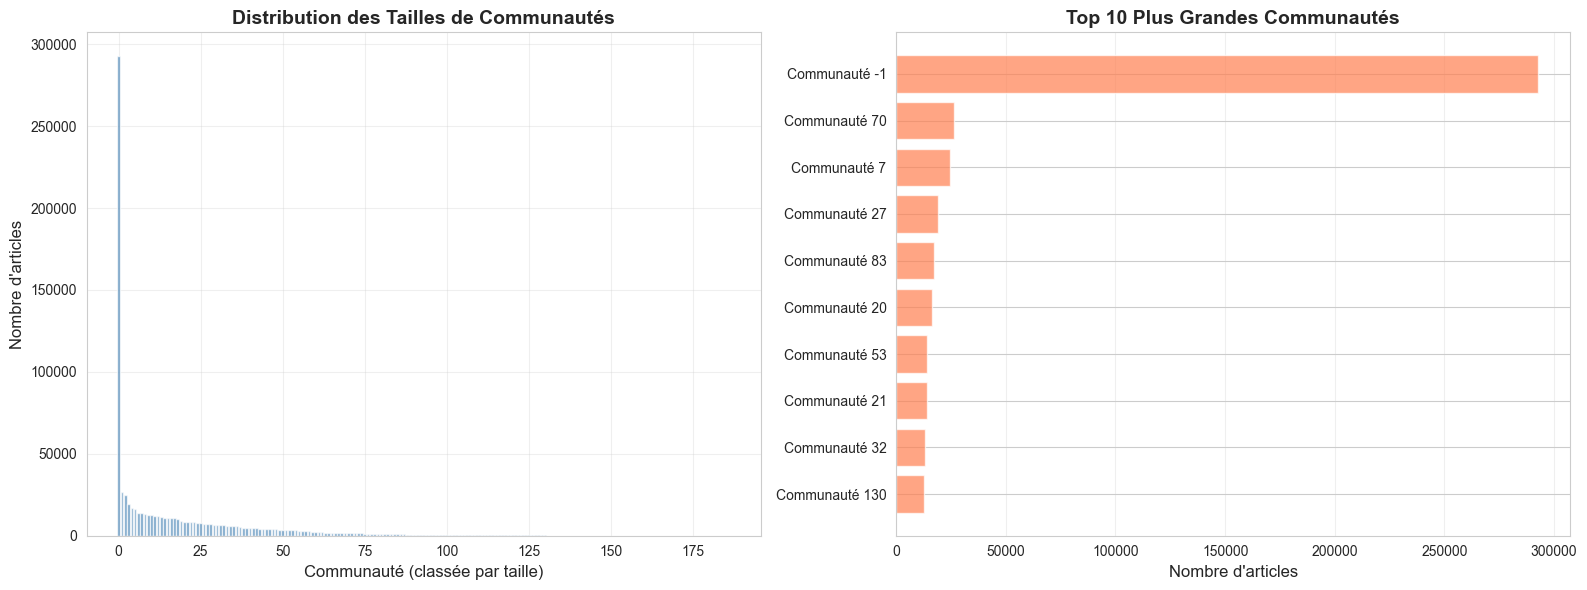


📊 Top 10 communautés:
   1. Communauté -1: 292706 articles
   2. Communauté 70: 26528 articles
   3. Communauté 7: 24600 articles
   4. Communauté 27: 19282 articles
   5. Communauté 83: 17095 articles
   6. Communauté 20: 16163 articles
   7. Communauté 53: 13881 articles
   8. Communauté 21: 13846 articles
   9. Communauté 32: 13153 articles
   10. Communauté 130: 12896 articles


In [21]:
comm_sizes = pd.Series(communities.values()).value_counts().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Distribution complète
ax1.bar(range(len(comm_sizes)), comm_sizes.values, color='steelblue', alpha=0.7)
ax1.set_xlabel('Communauté (classée par taille)', fontsize=12)
ax1.set_ylabel('Nombre d\'articles', fontsize=12)
ax1.set_title('Distribution des Tailles de Communautés', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Top 10
top10 = comm_sizes.head(10)
ax2.barh(range(len(top10)), top10.values, color='coral', alpha=0.7)
ax2.set_yticks(range(len(top10)))
ax2.set_yticklabels([f"Communauté {idx}" for idx in top10.index])
ax2.set_xlabel('Nombre d\'articles', fontsize=12)
ax2.set_title('Top 10 Plus Grandes Communautés', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 Top 10 communautés:")
for i, (comm_id, size) in enumerate(top10.items(), 1):
    print(f"   {i}. Communauté {comm_id}: {size} articles")

## 🔍 5. Explorer une Communauté

**Modifiez la variable `COMMUNITY_ID` ci-dessous pour explorer différentes communautés**

In [10]:
# ⚙️ PARAMÈTRE À MODIFIER
COMMUNITY_ID = 130  # Changer ce numéro

print(f"🔍 EXPLORATION DE LA COMMUNAUTÉ {COMMUNITY_ID}")
print("="*60)

# Filtrer les articles
comm_articles = df[df.index.map(lambda x: communities.get(x, -1) == COMMUNITY_ID)]

print(f"\n📚 Nombre d'articles: {len(comm_articles)}")

# Sous-graphe
subgraph = graph.subgraph(comm_articles.index.tolist())
print(f"\n🕸️  Graphe de la communauté:")
print(f"   - Nœuds: {subgraph.number_of_nodes()}")
print(f"   - Arêtes: {subgraph.number_of_edges()}")
print(f"   - Densité: {nx.density(subgraph):.4f}")

# Articles centraux
if len(subgraph) > 0:
    centrality = nx.degree_centrality(subgraph)
    top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print(f"\n⭐ Top 5 articles les plus centraux:")
    for i, (idx, cent) in enumerate(top_central, 1):
        print(f"   {i}. [{cent:.3f}] {df.iloc[idx]['title'][:70]}...")

# Exemples de titres
print(f"\n📄 Exemples de titres:")
for i, title in enumerate(comm_articles['title'].head(10), 1):
    print(f"   {i}. {title[:80]}...")

🔍 EXPLORATION DE LA COMMUNAUTÉ 130

📚 Nombre d'articles: 12896

🕸️  Graphe de la communauté:
   - Nœuds: 12896
   - Arêtes: 81722
   - Densité: 0.0010

⭐ Top 5 articles les plus centraux:
   1. [0.014] How COVID-19 kick-started online learning in medical education—The Dig...
   2. [0.014] Opinion of students on online education during the COVID-19 pandemic...
   3. [0.013] Academic Crisis During COVID 19: Online Classes, a Panacea for Imminen...
   4. [0.013] Adaptation to Online Technology for Learning during COVID-19 Pandemic:...
   5. [0.011] Students' Perception of Online Learning during Covid-19 Pandemic at Al...

📄 Exemples de titres:
   1. Digital technology adoption scale in the blended learning context in higher educ...
   2. Perceptions of Digital Health Education Among European Medical Students: Mixed M...
   3. Evaluating an Oncology Video Curriculum Designed to Promote Asynchronous Subspec...
   4. Digitale Lehre 2020: Studenten schätzen die Aufmerksamkeit während einer On

## 🎨 6. Visualiser la Communauté

⚠️  Affichage limité aux 100 nœuds les plus connectés


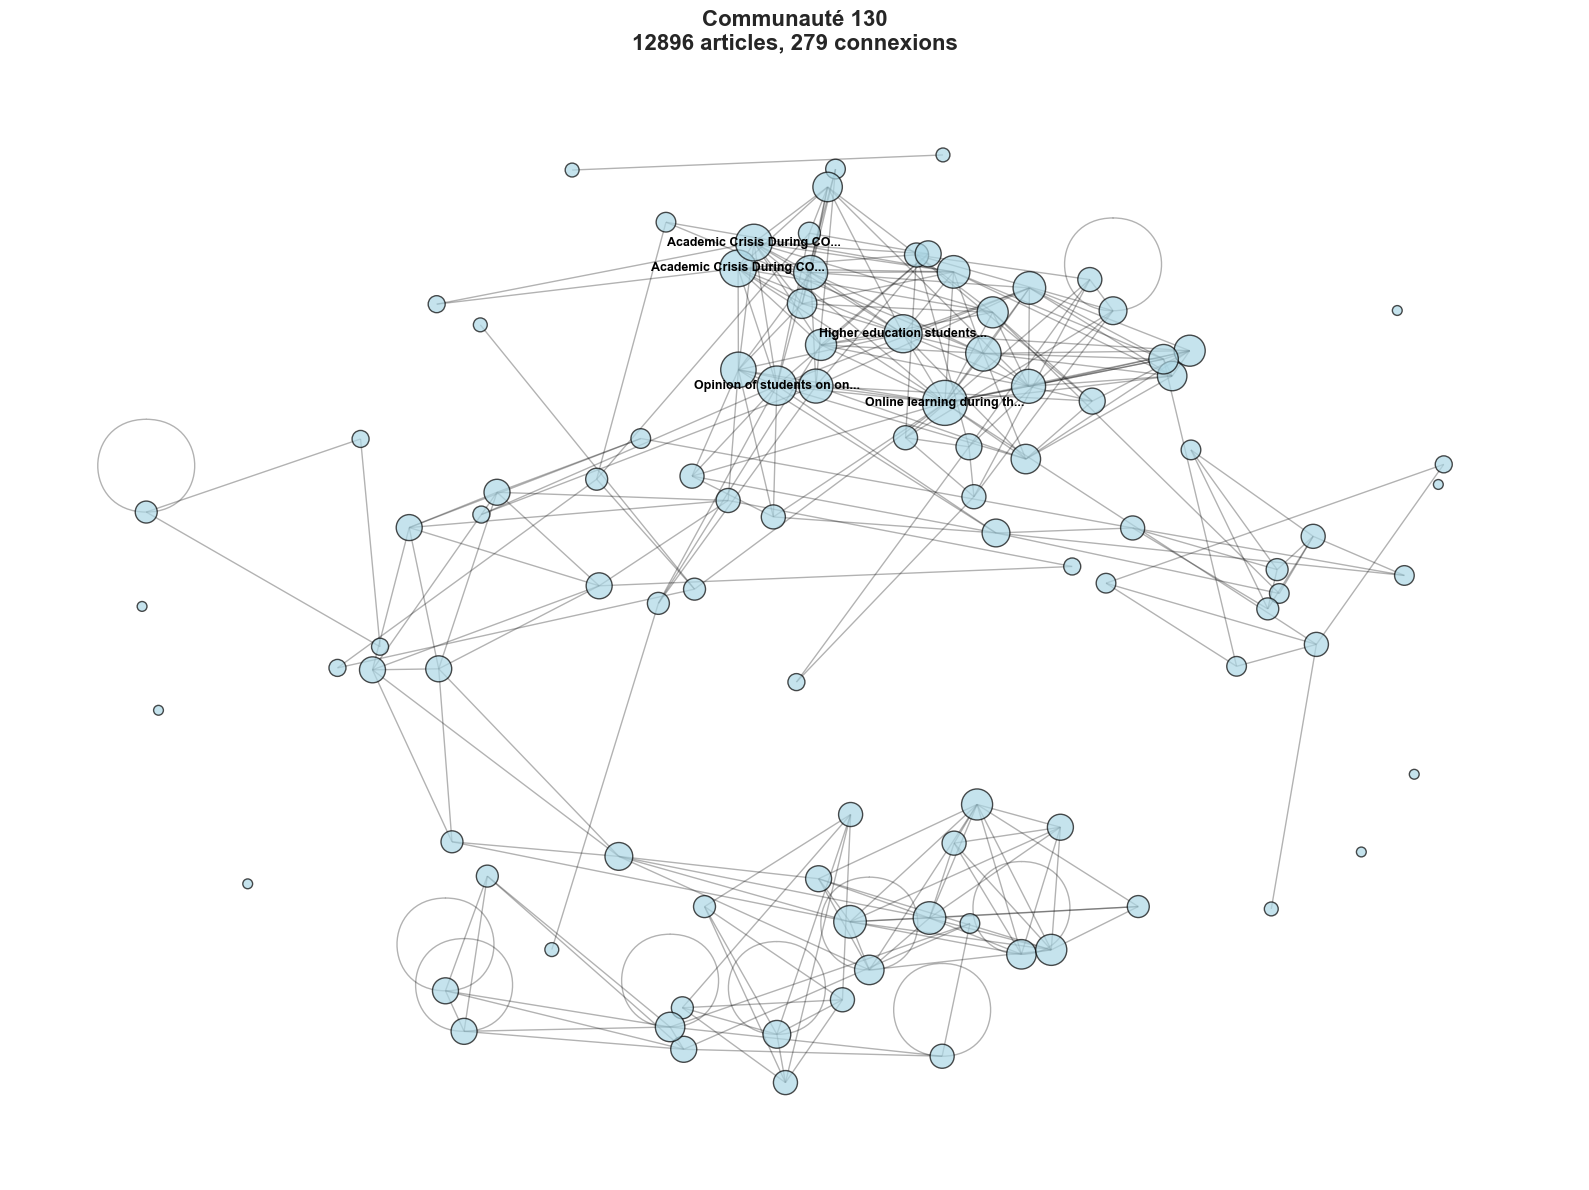

In [11]:
def visualize_community(community_id, max_nodes=100):
    """Visualise une communauté"""
    comm_articles = df[df.index.map(lambda x: communities.get(x) == community_id)]
    subgraph = graph.subgraph(comm_articles.index.tolist())
    
    # Limiter si trop grand
    if len(subgraph) > max_nodes:
        degrees = dict(subgraph.degree())
        top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
        subgraph = subgraph.subgraph(top_nodes)
        print(f"⚠️  Affichage limité aux {max_nodes} nœuds les plus connectés")
    
    # Layout
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)
    
    # Tailles basées sur le degré
    degrees = dict(subgraph.degree())
    node_sizes = [degrees[node] * 50 + 50 for node in subgraph.nodes()]
    
    # Visualisation
    plt.figure(figsize=(16, 12))
    
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,
                          node_color='lightblue', alpha=0.7, 
                          edgecolors='black', linewidths=1)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3, width=1)
    
    # Labels pour les 5 plus centraux
    centrality = nx.degree_centrality(subgraph)
    top_5 = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    labels = {node: df.iloc[node]['title'][:25] + '...' for node, _ in top_5}
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=9, font_weight='bold')
    
    plt.title(f"Communauté {community_id}\n{len(comm_articles)} articles, "
             f"{subgraph.number_of_edges()} connexions",
             fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualiser
visualize_community(COMMUNITY_ID, max_nodes=100)

## 🔎 7. Recherche Sémantique

**Modifiez la variable `QUERY` pour rechercher différents sujets**

In [13]:
from transformers import AutoTokenizer, AutoModel
import torch

def search_articles(query, top_k=10):
    """Recherche sémantique"""
    # Charger le modèle
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"💻 Device: {device}")
    
    tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
    model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased').to(device)
    model.eval()
    
    print(f"🔍 Recherche: '{query}'...")
    
    # Encoder la requête
    inputs = tokenizer(query, padding=True, truncation=True, 
                      max_length=512, return_tensors='pt').to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        query_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()[0]
    
    # Normaliser
    query_emb = query_emb / np.linalg.norm(query_emb)
    norm_emb = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    
    # Similarités
    similarities = np.dot(norm_emb, query_emb)
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    # Résultats
    results = df.iloc[top_indices].copy()
    results['similarity_score'] = similarities[top_indices]
    results['community'] = results.index.map(communities)
    
    return results[['title', 'abstract', 'similarity_score', 'community']]

In [ ]:

from sentence_transformers import SentenceTransformer
import torch

class SemanticSearch:
    """Recherche sémantique rapide"""
    
    def __init__(self, df, embeddings, communities=None, model_name='all-MiniLM-L6-v2'):
        self.df = df
        self.embeddings = embeddings
        self.communities = communities
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        print(f"Device: {self.device}")
        print(f"Chargement du modèle {model_name}...")
        self.model = SentenceTransformer(model_name)
        self.model.to(self.device)
        
        print("Normalisation des embeddings...")
        self.norm_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        print("Moteur prêt")
    
    def search(self, query, top_k=10, community_filter=None):
        query_emb = self.model.encode([query], normalize_embeddings=True)[0]
        similarities = np.dot(self.norm_embeddings, query_emb)
        
        if community_filter is not None and self.communities is not None:
            mask = np.array([self.communities.get(i, -1) == community_filter 
                           for i in range(len(self.df))])
            similarities[~mask] = -np.inf
        
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = self.df.iloc[top_indices].copy()
        results['similarity'] = similarities[top_indices]
        if self.communities:
            results['community'] = results.index.map(self.communities)
        
        return results

# Initialiser
search_engine = SemanticSearch(df, embeddings, communities)

Device: cpu
Chargement du modèle all-MiniLM-L6-v2...
Normalisation des embeddings...
Moteur prêt


In [ ]:

def quick_search(query, top_k=5):
    """Interface simple de recherche"""
    print(f"\nRecherche: '{query}'\n" + "="*70)
    
    results = search_engine.search(query, top_k=top_k)
    
    for i, (idx, row) in enumerate(results.iterrows(), 1):
        print(f"\n{i}. [Score: {row['similarity']:.3f}] [Comm: {row.get('community', 'N/A')}]")
        print(f"   Titre: {row['title']}")
        if pd.notna(row.get('abstract')):
            print(f"   Abstract: {row['abstract'][:200]}...")

print("Fonction quick_search prête")

Fonction quick_search prête


In [ ]:

quick_search("COVID-19 vaccine effectiveness", top_k=5)


Recherche: 'COVID-19 vaccine effectiveness'

1. [Score: 0.864] [Comm: 27]
   Titre: Breakthroughs, boosters, and beyond: a practical primer on current challenges with COVID-19
   Abstract: Identifying the extent to which breakthrough infections are contributing to the spread of COVID-19 can help guide vaccination policies and other infection prevention and control protocols to promote p...

2. [Score: 0.864] [Comm: 27]
   Titre: Breakthroughs, boosters, and beyond: a practical primer on current challenges with COVID-19
   Abstract: Identifying the extent to which breakthrough infections are contributing to the spread of COVID-19 can help guide vaccination policies and other infection prevention and control protocols to promote p...

3. [Score: 0.851] [Comm: 27]
   Titre: Vaccines for Covid‐19: An insight on their effectiveness and adverse effects
   Abstract: An era of SARS‐COVID‐19 outbreak with a high contagious percentage around the globe has been the subject of multi‐agency resear

## 🔗 8. Articles Similaires

**Trouvez des articles similaires à un article donné**

In [18]:
# ⚙️ PARAMÈTRE À MODIFIER
ARTICLE_INDEX = 0  # Changer cet index

print("\n" + "="*60)
print("ARTICLES SIMILAIRES")
print("="*60)

print(f"\n📄 Article de référence (index {ARTICLE_INDEX}):")
print(f"   {df.iloc[ARTICLE_INDEX]['title']}")
print(f"   Communauté: {communities.get(ARTICLE_INDEX)}\n")

# Calculer similarités
norm_emb = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
ref_emb = norm_emb[ARTICLE_INDEX]
similarities = np.dot(norm_emb, ref_emb)
similarities[ARTICLE_INDEX] = -1

top_indices = np.argsort(similarities)[::-1][:10]
similar = df.iloc[top_indices].copy()
similar['similarity_score'] = similarities[top_indices]
similar['community'] = similar.index.map(communities)

print(f"🔗 Top 10 articles similaires:\n")
for i, (idx, row) in enumerate(similar.iterrows(), 1):
    print(f"{i}. [Score: {row['similarity_score']:.3f}] [Comm: {row['community']}]")
    print(f"   {row['title']}\n")


ARTICLES SIMILAIRES

📄 Article de référence (index 0):
   Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia
   Communauté: 0

🔗 Top 10 articles similaires:

1. [Score: 0.863] [Comm: 0]
   Clinical manifestations in infants and children with Mycoplasma pneumoniae infection

2. [Score: 0.824] [Comm: 0]
   The study of Mycoplasma pneumonia infection among children with respiratory tract infection in hospital in Chengdu from 2014 to 2020

3. [Score: 0.822] [Comm: 0]
   Acute respiratory infection due to Mycoplasma pneumoniae: current status of diagnostic methods

4. [Score: 0.818] [Comm: 0]
   Results of molecular detection of Mycoplasma pneumoniae among patients with acute respiratory infection and in their household contacts reveals children as human reservoirs.

5. [Score: 0.810] [Comm: 0]
   Epidemiological and clinical analysis of community-acquired Mycoplasma pneumonia in children from a Spanish populatio

## 📊 9. Analyse des Mots-Clés

In [22]:
def analyze_keywords(community_id, top_n=20):
    """Analyse les mots-clés d'une communauté"""
    comm_articles = df[df.index.map(lambda x: communities.get(x) == community_id)]
    all_text = ' '.join(comm_articles['title'].dropna().tolist()).lower()
    
    stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 
                'for', 'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are'}
    
    words = all_text.split()
    word_counts = {}
    for word in words:
        word = word.strip('.,;:!?"()[]{}') 
        if len(word) > 3 and word not in stopwords and not word.isdigit():
            word_counts[word] = word_counts.get(word, 0) + 1
    
    return sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Analyser les top communautés
print("📊 MOTS-CLÉS PAR COMMUNAUTÉ")
print("="*60)

top_comms = comm_sizes.head(5)
for comm_id in top_comms.index:
    keywords = analyze_keywords(comm_id, top_n=10)
    print(f"\n🎯 Communauté {comm_id} ({top_comms[comm_id]} articles):")
    print("   Top 10 mots-clés:")
    for i, (word, count) in enumerate(keywords, 1):
        print(f"      {i}. {word} ({count})")

📊 MOTS-CLÉS PAR COMMUNAUTÉ

🎯 Communauté -1 (292706 articles):
   Top 10 mots-clés:
      1. covid-19 (39686)
      2. study (21023)
      3. during (18765)
      4. pandemic (17325)
      5. health (16721)
      6. review (12846)
      7. patients (12622)
      8. analysis (12596)
      9. using (12546)
      10. case (9411)

🎯 Communauté 70 (26528 articles):
   Top 10 mots-clés:
      1. covid-19 (20897)
      2. pandemic (11442)
      3. during (11002)
      4. health (7902)
      5. mental (6220)
      6. among (4507)
      7. study (4406)
      8. psychological (3861)
      9. anxiety (3439)
      10. impact (3365)

🎯 Communauté 7 (24600 articles):
   Top 10 mots-clés:
      1. covid-19 (17370)
      2. pandemic (4150)
      3. model (3864)
      4. epidemic (3168)
      5. analysis (2551)
      6. spread (1889)
      7. data (1885)
      8. using (1821)
      9. study (1795)
      10. during (1791)

🎯 Communauté 27 (19282 articles):
   Top 10 mots-clés:
      1. covid-19 (10625)


## 💾 10. Export des Résultats

In [23]:
# Exporter une communauté spécifique
COMM_TO_EXPORT = 0

OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

comm_articles = df[df.index.map(lambda x: communities.get(x) == COMM_TO_EXPORT)]
export_path = OUTPUT_DIR / f"community_{COMM_TO_EXPORT}_articles.csv"
comm_articles.to_csv(export_path, index=False)

print(f"✅ Communauté {COMM_TO_EXPORT} exportée: {export_path}")
print(f"   {len(comm_articles)} articles sauvegardés")

✅ Communauté 0 exportée: C:\Users\lapte\Desktop\AL\project\S1_CORD19_Classification\outputs\community_0_articles.csv
   10379 articles sauvegardés


## ✅ Fin de l'Exploration

Vous pouvez maintenant:
- Modifier les paramètres (COMMUNITY_ID, QUERY, ARTICLE_INDEX)
- Ré-exécuter les cellules pour explorer d'autres parties du dataset
- Créer vos propres analyses personnalisées